## Intro
No one likes jerky rides, we’ve been helping our driver-partners understand how they drive so they can become better drivers.

By collecting GPS, gyroscope and accelerometer data from our app during Grab trips, we are able to provide our driver-partners with weekly telematics reports on their driving patterns like speeding, acceleration and braking, so they know where they can do better.

Problem Appears to Sequential Problem But good Feature Engineering will turn this problem to  Structure Data Problem.  

#### NOTE: This is only proof of concept, Actual Model will be implemented using Apache BEAM, will be update later in this Repo 



# Engineered Features:
Features are decided upon primarily through domain knowledge and analysis of correlation.

|Engineered Features (Datapoint):|Description: |
| -------------                  |---|
|Harsh Accleration                |Harsh Accleration is Determined from acceleometer Z axis, if the accelertion is above threshold Value in m/s2.
|Harsh Braking                   |Harsh braking is sudden Decccleration that is Determined from acceleometer Z axis,  if the accelertion is below threshold Value in m/s2
|Harsh Turns                  |Harsh Turn is Determined from acceleometer x axis, if the accelertion is above threshold Value m/s2 in Both Direction
|Harsh Bumps                   |Harsh Bumps is Determined from acceleometer y axis, if the accelertion is above threshold Value m/s2 in Both Direction
|Change in Phone Orentation                   |Change in Phone orentation is determined from the change in gyro values
|Harsh Pitch                          |Harsh Pitch is determined from difference in pitch mean value of the bookingID + pitch threshold value,  
pitch = atan2((- acceleration_x) , sqrt(acceleration_y * acceleration_y + acceleration_z * acceleration_z)) * 57.3
|Harsh Roll                          |Harsh Roll is determined from difference in roll mean value of the bookingID + roll hreshold value,  
roll = atan2(y_Buff , z_Buff) * 57.3
|Harsh Speeding(Exceding Speed Limit)                           |Speed above Treshold Values
|Distance                     |Distance based on Time * Average Speed, Distance is used to penalize the above value based on Distance of the BookingID

##### Statical Feature mean, average and std deviation were added to increase the accuracy. But didn't Help. 
##### Feature is bucketies to get more accuracy 

#### Feature Correlation Map

 <td> <img src="img/heatmap.png" alt="Drawing" style="width: 600px;"/> </td>

|FeatureData Features (Datapoint):|Description: |
| -------------                  |---|
|Pitch                |Correlation With Acceleration, Braking and Bumps
|Roll                |Turns
|Braking                |Don't Corelate with Acceleration and correlate with Pitch 
|Phone Orientation                |Correlate with Pitch Roll, Acceleration, Braking and Turns
 Did feature bucketing To increase the accuracy. 



#### Final Model accuracy

<td> <img src="img/final_model.png" alt="Drawing" style="width: 1000px;"/> </td>


#### Conclusion
#### Best model is gradient boosted decision tree, need more data to increase accuracy, try Deep Neural Network like LinearClassification, LinearDNNClassifier, Custom Estimators. Still we cannot increase the accuracy.
#### Even consider bucketizing the features and added second order polynomials features, still cannot increase the accuracy. I need more data to increase accuracy and prove my hypothesis.

### Implemention

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import shutil
import tensorflow as tf
import glob
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
%matplotlib inline
print(tf.__version__)
pd.options.display.float_format = '{:.5f}'.format

1.13.1


In [2]:
### Disable PLot. 
enableGraph=False

### Exploratory data analysis

dfRaw will contain all event types, and df will contain only events relevant for analysis, such as behavioral events (harsh turns, accelerations etc.)

To read the data from file:

In [3]:

def read_dataset(path_feature, path_label):
    all_files_feature = glob.glob(path_feature + "/*.csv")
    all_files_label = glob.glob(path_label + "/*.csv")
    li=[]
    for filename in all_files_feature:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    df_features = pd.concat(li, axis=0, ignore_index=True)
    li=[]
    for filename in all_files_label:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    df_labels = pd.concat(li, axis=0, ignore_index=True)
    dfRaw= (pd.merge(df_features, df_labels, left_on='bookingID', right_on='bookingID', how='left'))
    return dfRaw, df_labels
dfRaw, df_labels = read_dataset(r'C:\Users\sekaranh\Documents\Python Scripts\safty\dataset\features', r'C:\Users\sekaranh\Documents\Python Scripts\safty\dataset\labels' )

In [4]:
dfRaw.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,1202590843006,3.00000,353.00000,1.22887,8.90010,3.98697,0.00822,0.00227,-0.00997,1362.00000,0.00000,1
1,274877907034,9.29300,17.00000,0.03277,8.65993,4.73730,0.02463,0.00403,-0.01086,257.00000,0.19000,1
2,884763263056,3.00000,189.00000,1.13967,9.54597,1.95133,-0.00690,-0.01508,0.00112,973.00000,0.66706,1
3,1073741824054,3.90000,126.00000,3.87154,10.38636,-0.13647,0.00134,-0.33960,-0.01796,902.00000,7.91329,0
4,1056561954943,3.90000,50.00000,-0.11288,10.55096,-1.56011,0.13057,-0.06170,0.16153,820.00000,20.41941,1


### Cleaning Dataset
Removing NA , Clamping Speed to 200km, Seconds to 24 hours Max. Dropping off label which toggle between 1 and 0 because of uncertainty

In [5]:
RELEVANT_EVENTS = ['bookingID','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x','gyro_y','gyro_z',
        'second', 'Bearing', 'Speed', 'label']

def prepData(dfPrepData, minRecordsPerSubscriber = 1):
    dfPrepData.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfPrepData),"***")
  
    
    #Remove NAs
    dfPrepData = dfPrepData.dropna()
    print("Removed NAs. Length:",len(dfPrepData))
    
    #Remove Negative Speed
    #dfPrepData['Speed']=dfPrepData.Speed.clip(0,10000)
    print("Changing Speed to abs Speed")
    #dfPrepData['Speed']=abs(dfPrepData['Speed'])
    dfPrepData.drop(dfPrepData[dfPrepData['Speed'] >  100].index, inplace=True) 
    dfPrepData.drop(dfPrepData[dfPrepData['Speed'] <  0].index, inplace=True) 
    
    #Filter out second more then 86400 second, 24H
    dfPrepData.drop(dfPrepData[dfPrepData['second'] >  86400].index, inplace=True)
    print("Filter out second more than 86400 second, 24H")
    
    dfPrepData.drop(dfPrepData[dfPrepData['Accuracy'] >  50].index, inplace=True)
    print("Drop coloum accuracy less then 50")

    # Filter out unwanted events
    drop_these = list(set(list(dfPrepData)) - set(RELEVANT_EVENTS))
    df =  dfPrepData.drop(drop_these, axis = 1)
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    eventCountPerDriver = df.groupby('bookingID')['bookingID'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.bookingID.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))
    return df
df = prepData(dfRaw)

*** Starting data prep. Length: 16154418 ***
Removed NAs. Length: 16154418
Changing Speed to abs Speed
Filter out second more than 86400 second, 24H
Drop coloum accuracy less then 50
Keeping only events that are relevant for modeling. Length: 15894164
Filtering users with too few samples. Length: 15894163


### Feature Engineering
Creating New Feature , Since raw Sensor Information is diffcult to correlate with Safty of the ride . so Creating New Feature Like Harsh Acceleration, Harsh Braking, Harsh Turns and Harsh Bumps, Ride Distance and Change in Phone Orrenataion, Hash Pitch and Hash Roll Based On research paper https://www.researchgate.net/publication/260543538_Safe_Driving_Using_Mobile_Phones 
Pitch and Roll is determine from Acclerometer https://wiki.dfrobot.com/How_to_Use_a_Three-Axis_Accelerometer_for_Tilt_Sensing 
    <tr>
    <td> <img src="img/post1-2figure2.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src= "https://developer.android.com/images/axis_device.png" alt="Drawing" style="width: 250px;"/> </td>
    </tr>

pitch = atan2((- acceleration_x) , sqrt(acceleration_y * acceleration_y + acceleration_z * acceleration_z)) * 57.3;

roll = atan2(y_Buff , z_Buff) * 57.3;

In [6]:
## reference https://wiki.dfrobot.com/How_to_Use_a_Three-Axis_Accelerometer_for_Tilt_Sensing
#pitch = atan2((- x_Buff) , sqrt(y_Buff * y_Buff + z_Buff * z_Buff)) * 57.3;
#df['pitch'] = np.arctan2(df['acceleration_y']/np.sqrt(np.square(df['acceleration_x'])+np.square(df['acceleration_z'])))
df['f_pitch'] = np.arctan2(-df['acceleration_y'],np.sqrt(np.square(df['acceleration_z'])+np.square(df['acceleration_x'])))*57.3
#roll = atan2(y_Buff , z_Buff) * 57.3;
df['f_roll'] = np.arctan2(df['acceleration_z'],df['acceleration_x'])*57.3

df['f_gyro'] = abs(df['gyro_x']) + abs(df['gyro_y']) + abs(df['gyro_z'])
df['f_accel'] = abs(df['acceleration_x']) + abs(df['acceleration_y']) + abs(df['acceleration_z'])
df['f_bearing'] = df['Bearing']
df['f_speed'] =  df['Speed']

There Are scenarios in Data, where phone is lay flat, where phone don’t have orientation , axis is determine from gravity and previous orientation

In [7]:
print("finding orentation and swaping acceleration")
m = abs(df['acceleration_y']) < abs(df['acceleration_z'])
df.loc[m, ['acceleration_y', 'acceleration_z']] = df.loc[m, ['acceleration_z', 'acceleration_y']].values 

finding orentation and swaping acceleration


Remove Gravity Interference from the acclerometer for better isloation and adding positive values to z-axis to say car isn't in stationery

In [8]:
print("finding acceleration mean and offseting the values")
df['acceleration_z']= df.groupby('bookingID')['acceleration_z'].transform(lambda x: (x - x.mean()/2))#/x.std())
df['acceleration_x']= df.groupby('bookingID')['acceleration_x'].transform(lambda x: (x - x.mean()))#/x.std())
df['acceleration_y']= df.groupby('bookingID')['acceleration_y'].transform(lambda x: (x - x.mean()))#/x.std())
df['f_diffPitchMean']= df.groupby('bookingID')['f_pitch'].transform(lambda x: (x - x.mean()))
df['f_diffRollMean']= df.groupby('bookingID')['f_roll'].transform(lambda x: (x - x.mean()))


finding acceleration mean and offseting the values


In [9]:
#parameter turning values
hash_acceleration_value = 3 #m/s
hash_braking_value = -2 
hash_turn_value = 2
hash_bump_value = 3
hash_pitch_value =10
hash_roll_value =20
max_speed_value = 100

In [10]:
df.head()

,bookingID,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,f_pitch,f_roll,f_gyro,f_accel,f_bearing,f_speed,f_diffPitchMean,f_diffRollMean
0,1202590843006,353.00000,-0.01336,-0.07823,1.98769,0.00822,0.00227,-0.00997,1362.00000,0.00000,1,-64.88925,72.87498,0.02046,14.11594,353.00000,0.00000,-0.05150,0.29465
1,274877907034,17.00000,-0.31496,-0.32090,2.67161,0.02463,0.00403,-0.01086,257.00000,0.19000,1,-61.32367,89.61021,0.03952,13.43001,17.00000,0.19000,3.75836,4.46500
2,884763263056,189.00000,0.68389,0.10154,0.63521,-0.00690,-0.01508,0.00112,973.00000,0.66706,1,-76.68747,59.71737,0.02310,12.63698,189.00000,0.66706,-2.93941,-20.83731
3,1073741824054,126.00000,3.17059,0.62018,-0.31855,0.00134,-0.33960,-0.01796,902.00000,7.91329,0,-69.55041,-2.01902,0.35890,14.39438,126.00000,7.91329,12.60117,-21.95132
4,1056561954943,50.00000,-0.05995,0.81488,-1.04793,0.13057,-0.06170,0.16153,820.00000,20.41941,1,-81.57328,-94.14536,0.35380,12.22395,50.00000,20.41941,-0.70516,-31.19935


In [11]:
# featureDerivative = { 
#                      'hashAcceleration' : ['acceleration_z', hash_acceleration_value],
#                      'hashBraking' : ['acceleration_z', hash_braking_value],
#                      'hashTurn' : ['acceleration_x', hash_braking_value] ,
#                      'hashPitch' : ['diffPitchMean', hash_pitch_value],
#                      'hashRoll':['diffRollMean', hash_roll_value]
#                     } 
# for feature_name, col_parameter in featureDerivative.items(): 
#     if col_parameter[1] > 0 : 
#         df[feature_name] = df[col_parameter[0]].apply(lambda x: 1 if x > col_parameter[1] else 0)
#     else:
#         df[feature_name] = df[col_parameter[0]].apply(lambda x: 1 if x < col_parameter[1] else 0)

determine the Harsh Acceleraion , Harsh Braking, Harsh Turns and Harsh Bump , Have Wider Mode for Following feature.
refer https://www.researchgate.net/publication/260543538_Safe_Driving_Using_Mobile_Phones 

In [12]:
def create_newFeature(df_feature):
    df_feature['speed_km/h'] = df_feature['Speed']*3.6
    df_feature['harshAcceleration'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x > hash_acceleration_value and x < hash_acceleration_value+2)   else 0)
    df_feature['harshAcceleration1'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x > hash_acceleration_value+2)   else 0)
    df_feature['harshBraking'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x < hash_braking_value and x > hash_braking_value-2 ) else 0)
    df_feature['harshBraking1'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x < hash_braking_value-2 ) else 0)
    df_feature['harsh_orientationChange'] = df_feature['f_gyro'].apply(lambda x: 1 if abs(x) > 1 else 0)
    df_feature['harsh_speed_limit'] = df_feature['speed_km/h'].apply(lambda x: 1 if x > max_speed_value else 0)
    df_feature['harshTurn'] = df_feature['acceleration_x'].apply(lambda x: 1 if (abs(x) > hash_turn_value and abs(x) < hash_turn_value+2 ) else 0)
    df_feature['harshTurn1'] = df_feature['acceleration_x'].apply(lambda x: 1 if (abs(x) > hash_turn_value+2 ) else 0)
    df_feature['harshBump'] = df_feature['acceleration_y'].apply(lambda x: 1 if (abs(x) > hash_bump_value and abs(x) < hash_bump_value+2) else 0)
    df_feature['harshBump1'] = df_feature['acceleration_y'].apply(lambda x: 1 if (abs(x) > hash_bump_value+2) else 0)
    df_feature['harshPitch'] = df_feature['f_diffPitchMean'].apply(lambda x: 1 if (abs(x) > hash_pitch_value and abs(x)< hash_pitch_value+10) else 0)
    df_feature['harshPitch1'] = df_feature['f_diffPitchMean'].apply(lambda x: 1 if (abs(x) > hash_pitch_value+10) else 0) 
    df_feature['harshRoll'] = df_feature['f_diffRollMean'].apply(lambda x: 1 if (abs(x) > hash_roll_value and abs(x)< hash_roll_value+10) else 0)
    df_feature['harshRoll1'] = df_feature['f_diffRollMean'].apply(lambda x: 1 if (abs(x) > hash_pitch_value) else 0)
    return df_feature
df=create_newFeature(df)
df.head(10)

,bookingID,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,...,harsh_orientationChange,harsh_speed_limit,harshTurn,harshTurn1,harshBump,harshBump1,harshPitch,harshPitch1,harshRoll,harshRoll1
0,1202590843006,353.00000,-0.01336,-0.07823,1.98769,0.00822,0.00227,-0.00997,1362.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
1,274877907034,17.00000,-0.31496,-0.32090,2.67161,0.02463,0.00403,-0.01086,257.00000,0.19000,...,0,0,0,0,0,0,0,0,0,0
2,884763263056,189.00000,0.68389,0.10154,0.63521,-0.00690,-0.01508,0.00112,973.00000,0.66706,...,0,0,0,0,0,0,0,0,1,1
3,1073741824054,126.00000,3.17059,0.62018,-0.31855,0.00134,-0.33960,-0.01796,902.00000,7.91329,...,0,0,1,0,0,0,1,0,1,1
4,1056561954943,50.00000,-0.05995,0.81488,-1.04793,0.13057,-0.06170,0.16153,820.00000,20.41941,...,0,0,0,0,0,0,0,0,0,1
5,1185410973787,178.00000,0.29140,0.20354,0.97906,-0.05710,-0.04355,0.00233,533.00000,19.25000,...,0,0,0,0,0,0,0,0,0,0
6,163208757379,262.18442,0.17645,0.11611,-1.21214,0.02677,-0.03069,-0.00607,556.00000,2.11000,...,0,0,0,0,0,0,0,0,0,0
7,884763262976,48.00000,-0.16815,0.12047,-0.08033,-0.00070,-0.00190,0.01559,200.00000,0.00000,...,0,0,0,0,0,0,0,0,1,1
8,841813590178,44.04170,-0.07583,0.01636,-2.68655,0.01377,-0.01708,0.00323,115.00000,13.91465,...,0,0,0,0,0,0,0,0,0,0
9,300647710810,165.00000,0.05394,-0.02938,2.09363,0.02136,0.00161,0.00938,824.00000,26.60288,...,0,0,0,0,0,0,0,0,0,0


Clustering the Following Feature

In [13]:
def cluster_Feature(df):
    prefixes = ["harsh", "speed",'orientation']
    prefixes_f = ['f_']
    df_safty = pd.DataFrame()
    bookingIDs= df.bookingID.unique()
    df_safty['bookingID'] = bookingIDs
    for df_columns_name in df.columns :
        if df_columns_name.startswith(tuple(prefixes)):
                df_safty1 =df.groupby('bookingID')[df_columns_name].sum().reset_index()
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
        if df_columns_name.startswith(tuple(prefixes_f)):
                df_safty1 =df.groupby('bookingID')[df_columns_name].mean().reset_index()
                df_safty1.columns = ['bookingID', df_columns_name+"_mean"]
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
                df_safty1 =df.groupby('bookingID')[df_columns_name].max().reset_index()
                df_safty1.columns = ['bookingID', df_columns_name+"_max"]
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
                df_safty1 =df.groupby('bookingID')[df_columns_name].std().reset_index()
                df_safty1.columns = ['bookingID', df_columns_name+"_std"]
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
                
    return df_safty
df_safty=cluster_Feature(df)
df_safty.head(10)

,bookingID,f_pitch_mean,f_pitch_max,f_pitch_std,f_roll_mean,f_roll_max,f_roll_std,f_gyro_mean,f_gyro_max,f_gyro_std,...,harsh_orientationChange,harsh_speed_limit,harshTurn,harshTurn1,harshBump,harshBump1,harshPitch,harshPitch1,harshRoll,harshRoll1
0,1202590843006,-64.83775,-44.53816,5.42919,72.58033,107.29085,8.64316,0.12827,1.43464,0.14019,...,2,0,20,0,2,0,100,1,38,198
1,274877907034,-65.08203,-46.83193,3.02289,85.14521,121.67448,6.56035,0.04428,0.75961,0.08290,...,0,4,8,0,0,0,17,0,24,145
2,884763263056,-73.74806,-44.13417,4.21105,80.55469,155.63778,16.37695,0.17819,1.47024,0.16258,...,4,0,24,0,2,0,60,1,130,721
3,1073741824054,-82.15158,-50.66321,4.91920,19.93231,178.38816,60.72369,0.16204,1.96414,0.17618,...,3,0,56,0,7,1,39,4,114,808
4,1056561954943,-80.86812,-30.16102,5.32966,-62.94602,179.13977,79.72628,0.24794,1.83136,0.19267,...,4,0,60,2,10,2,41,3,146,804
5,1185410973787,-65.36784,-31.68921,7.29994,80.97380,167.51633,23.28477,0.18557,1.63954,0.18610,...,4,5,76,7,3,0,159,19,78,399
6,163208757379,73.69823,85.11406,3.61053,-80.04927,-21.81032,13.84089,0.14157,0.78553,0.11648,...,0,0,4,0,0,0,7,0,25,117
7,884763262976,-85.09385,-51.75023,4.08665,-32.01335,179.84508,70.58515,0.19474,1.49601,0.21301,...,7,0,14,0,6,0,24,2,97,733
8,841813590178,49.77278,64.17592,4.40196,-77.08473,-43.62290,7.43668,0.12247,0.93357,0.12807,...,0,130,42,0,0,0,40,2,26,142
9,300647710810,-53.64412,-32.85000,5.19549,81.67475,154.91335,8.06805,0.19437,1.35413,0.17444,...,5,0,42,1,1,0,103,4,33,227


Looking at the absolute number of the events is wrong. Instead we'll normalize the number of events per booking based on booking Distance. Distance is calculated based on time and average speed. Since some data is missing in sequential time instead max seconds, I took seconds count.

In [14]:
def total_distance(oneBooking):
    return (oneBooking.second.count()* (abs(oneBooking.Speed.mean()) if oneBooking.Speed.mean() > 5.5 else 5.5))#
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerBooking = dfRaw.groupby('bookingID').apply(total_distance).reset_index(name='Distance')
    return dfDistancePerBooking
distancePerBooking = calculate_overall_distance_travelled(dfRaw)
distancePerBooking.head(10)

,bookingID,Distance
0,0,9030.80122
1,1,6707.23123
2,2,1072.50000
3,4,6729.19001
4,6,6022.50000
5,7,11555.39035
6,8,2128.50000
7,10,3263.26000
8,11,1498.28032
9,13,38121.83062


In [15]:
def create_feature_set(df, distancePerBooking):
    dfEventMatrix = df.merge(distancePerBooking, how = 'inner',on='bookingID')
    dfEventMatrix.set_index('bookingID', inplace=True)
    featureCols = [col for col in dfEventMatrix if col.startswith('harsh')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['Distance'], axis=0)
    dfFeatureSet = dfEventMatrix[featureCols]
    return dfFeatureSet
features_h = create_feature_set(df_safty,distancePerBooking)
features_h.head(10)

,harshAcceleration,harshAcceleration1,harshBraking,harshBraking1,harsh_orientationChange,harsh_speed_limit,harshTurn,harshTurn1,harshBump,harshBump1,harshPitch,harshPitch1,harshRoll,harshRoll1
bookingID,,,,,,,,,,,,,,
1202590843006,0.02196,0.00047,0.00000,0.00000,0.00032,0.00000,0.00316,0.00000,0.00032,0.00000,0.01580,0.00016,0.00600,0.03128
274877907034,0.00313,0.00000,0.00000,0.00000,0.00000,0.00019,0.00038,0.00000,0.00000,0.00000,0.00082,0.00000,0.00115,0.00697
884763263056,0.00157,0.00004,0.00000,0.00000,0.00018,0.00000,0.00108,0.00000,0.00009,0.00000,0.00270,0.00004,0.00584,0.03239
1073741824054,0.00129,0.00029,0.00459,0.00043,0.00043,0.00000,0.00802,0.00000,0.00100,0.00014,0.00559,0.00057,0.01634,0.11578
1056561954943,0.00021,0.00000,0.00459,0.00027,0.00027,0.00000,0.00411,0.00014,0.00068,0.00014,0.00281,0.00021,0.00999,0.05504
1185410973787,0.01692,0.00224,0.00084,0.00009,0.00037,0.00047,0.00711,0.00065,0.00028,0.00000,0.01486,0.00178,0.00729,0.03730
163208757379,0.00000,0.00000,0.01355,0.00000,0.00000,0.00000,0.00126,0.00000,0.00000,0.00000,0.00221,0.00000,0.00788,0.03687
884763262976,0.00042,0.00000,0.00291,0.00021,0.00145,0.00000,0.00291,0.00000,0.00125,0.00000,0.00498,0.00042,0.02013,0.15213
841813590178,0.00000,0.00000,0.07009,0.00235,0.00000,0.00953,0.00308,0.00000,0.00000,0.00000,0.00293,0.00015,0.00191,0.01041


To Increase the Accuracy adding the static Model also

In [16]:
def create_feature_set_stats(df):
    dfEventMatrix = df.merge(distancePerBooking, how = 'inner',on='bookingID')
    dfEventMatrix.set_index('bookingID', inplace=True)
    featureCols = [col for col in dfEventMatrix if col.startswith('f_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols]
    dfFeatureSet = dfEventMatrix[featureCols]
    return dfFeatureSet
features_f = create_feature_set_stats(df_safty)
features_f.head(10)

,f_pitch_mean,f_pitch_max,f_pitch_std,f_roll_mean,f_roll_max,f_roll_std,f_gyro_mean,f_gyro_max,f_gyro_std,f_accel_mean,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,-64.83775,-44.53816,5.42919,72.58033,107.29085,8.64316,0.12827,1.43464,0.14019,14.25286,...,143.90789,5.47892,18.99044,5.73274,-0.00000,20.29959,5.42919,0.00000,34.71053,8.64316
274877907034,-65.08203,-46.83193,3.02289,85.14521,121.67448,6.56035,0.04428,0.75961,0.08290,13.54314,...,71.21136,12.91328,28.64000,11.16940,-0.00000,18.25010,3.02289,-0.00000,36.52927,6.56035
884763263056,-73.74806,-44.13417,4.21105,80.55469,155.63778,16.37695,0.17819,1.47024,0.16258,12.73569,...,85.13190,13.41796,26.93222,9.53114,0.00000,29.61389,4.21105,-0.00000,75.08309,16.37695
1073741824054,-82.15158,-50.66321,4.91920,19.93231,178.38816,60.72369,0.16204,1.96414,0.17618,11.49918,...,71.37138,6.68472,19.29979,5.82605,-0.00000,31.48837,4.91920,0.00000,158.45585,60.72369
1056561954943,-80.86812,-30.16102,5.32966,-62.94602,179.13977,79.72628,0.24794,1.83136,0.19267,11.70425,...,115.78183,16.23169,24.05778,6.28874,0.00000,50.70711,5.32966,0.00000,242.08578,79.72628
1185410973787,-65.36784,-31.68921,7.29994,80.97380,167.51633,23.28477,0.18557,1.63954,0.18610,13.83282,...,82.01196,9.69057,29.31000,7.92586,0.00000,33.67863,7.29994,-0.00000,86.54252,23.28477
163208757379,73.69823,85.11406,3.61053,-80.04927,-21.81032,13.84089,0.14157,0.78553,0.11648,12.49882,...,64.50592,5.76902,17.17000,5.16750,-0.00000,11.41583,3.61053,0.00000,58.23896,13.84089
884763262976,-85.09385,-51.75023,4.08665,-32.01335,179.84508,70.58515,0.19474,1.49601,0.21301,11.00045,...,75.65172,5.71464,18.21703,5.95163,-0.00000,33.34362,4.08665,-0.00000,211.85844,70.58515
841813590178,49.77278,64.17592,4.40196,-77.08473,-43.62290,7.43668,0.12247,0.93357,0.12807,14.82121,...,77.86049,13.25603,32.24221,10.25341,-0.00000,14.40314,4.40196,0.00000,33.46183,7.43668


In [17]:
features = pd.merge(features_h,features_f, left_on='bookingID', right_on='bookingID', how='left')
features.head()

,harshAcceleration,harshAcceleration1,harshBraking,harshBraking1,harsh_orientationChange,harsh_speed_limit,harshTurn,harshTurn1,harshBump,harshBump1,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,0.02196,0.00047,0.00000,0.00000,0.00032,0.00000,0.00316,0.00000,0.00032,0.00000,...,143.90789,5.47892,18.99044,5.73274,-0.00000,20.29959,5.42919,0.00000,34.71053,8.64316
274877907034,0.00313,0.00000,0.00000,0.00000,0.00000,0.00019,0.00038,0.00000,0.00000,0.00000,...,71.21136,12.91328,28.64000,11.16940,-0.00000,18.25010,3.02289,-0.00000,36.52927,6.56035
884763263056,0.00157,0.00004,0.00000,0.00000,0.00018,0.00000,0.00108,0.00000,0.00009,0.00000,...,85.13190,13.41796,26.93222,9.53114,0.00000,29.61389,4.21105,-0.00000,75.08309,16.37695
1073741824054,0.00129,0.00029,0.00459,0.00043,0.00043,0.00000,0.00802,0.00000,0.00100,0.00014,...,71.37138,6.68472,19.29979,5.82605,-0.00000,31.48837,4.91920,0.00000,158.45585,60.72369
1056561954943,0.00021,0.00000,0.00459,0.00027,0.00027,0.00000,0.00411,0.00014,0.00068,0.00014,...,115.78183,16.23169,24.05778,6.28874,0.00000,50.70711,5.32966,0.00000,242.08578,79.72628


In [18]:
# features_DNN= (pd.merge(features, df_labels, left_on='bookingID', right_on='bookingID', how='left'))
# msk = np.random.rand(len(features_DNN)) < 0.8
# traindf = features_DNN[msk]
# evaldf = features_DNN[~msk]
# traindf.to_csv('train.csv',index=False,header=False)
# evaldf.to_csv('eval.csv' ,index=False,header=False)

In [19]:
features.head()

,harshAcceleration,harshAcceleration1,harshBraking,harshBraking1,harsh_orientationChange,harsh_speed_limit,harshTurn,harshTurn1,harshBump,harshBump1,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,0.02196,0.00047,0.00000,0.00000,0.00032,0.00000,0.00316,0.00000,0.00032,0.00000,...,143.90789,5.47892,18.99044,5.73274,-0.00000,20.29959,5.42919,0.00000,34.71053,8.64316
274877907034,0.00313,0.00000,0.00000,0.00000,0.00000,0.00019,0.00038,0.00000,0.00000,0.00000,...,71.21136,12.91328,28.64000,11.16940,-0.00000,18.25010,3.02289,-0.00000,36.52927,6.56035
884763263056,0.00157,0.00004,0.00000,0.00000,0.00018,0.00000,0.00108,0.00000,0.00009,0.00000,...,85.13190,13.41796,26.93222,9.53114,0.00000,29.61389,4.21105,-0.00000,75.08309,16.37695
1073741824054,0.00129,0.00029,0.00459,0.00043,0.00043,0.00000,0.00802,0.00000,0.00100,0.00014,...,71.37138,6.68472,19.29979,5.82605,-0.00000,31.48837,4.91920,0.00000,158.45585,60.72369
1056561954943,0.00021,0.00000,0.00459,0.00027,0.00027,0.00000,0.00411,0.00014,0.00068,0.00014,...,115.78183,16.23169,24.05778,6.28874,0.00000,50.70711,5.32966,0.00000,242.08578,79.72628


### Correlations Between Events Are accurate , pitch is coreleationg with Acceleration role with turn, braking and acclerion are in oppsite Direction

In [20]:
import seaborn as sns

def create_heat_map_plt(features):
    if True:
        corr = features.corr()

        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        fig = plt.figure()

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(7, 7))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.savefig('heatmap')

<Figure size 432x288 with 0 Axes>

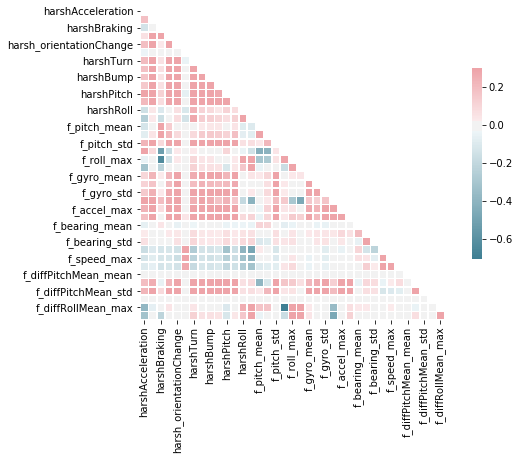

In [21]:
create_heat_map_plt(features)

### Modeling Hypotheseis

Our Assumpation is BookingID with Less Events will drive safly and BookingID with more Events is Unsafe. Events are harsh braking, harsh acceleration, harsh turns, harsh bumps, harsh pitch and harsh roll.

In [22]:
import seaborn as sns
def create_scatterplot(features):
    if enableGraph:
        sns.set(style="ticks",font_scale=1.1)
        g = sns.PairGrid(features)
        g = g.map_upper(plt.scatter, edgecolor="w")
        g = g.map_lower(sns.kdeplot)
        g = g.map_diag(plt.hist, edgecolor="w")

All features are skewed to the right with a long tail. On the diagnoal, we see a histogram of all features. On the upper triangle we see a scatterplot of each pair of features, and on the bottom triangle we see a KDE (Kernel Density Estimation) of each pair of features

In [23]:
import scipy.stats as st

def transform_to_normal_boxcox(x,min_max_transform = False):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    if min_max_transform:
        xt = (xt - np.min(xt)) / (np.max(xt)-np.min(xt))
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal_boxcox(x,min_max_transform = True)))
transFeatures.head()
create_scatterplot(transFeatures)

Outliers handling¶
We wish to remove/adjust outliers as they affect many statistical approaches. In order to remove these, we'll transform the features to normal (using a box-cox transformation) and remove based on mean + kstd's* rule. A second approach could be to truncate the tail using some constant, but it will be more difficult to find this threshold than the standard deviation rule. A third option is to remove outliers on all three dimensions (using a multivariate normal distribution, for example).

This code performs the first option, box-cox transformation:

In [24]:
### remove outliers
import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor =10, normalize = False):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal_boxcox(x)

    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    if normalize:
        #Normalize to [0,1]
        x = (x - np.min(x)) / (np.max(x)-np.min(x))
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x)))
cleanFeatures.head(6)
create_scatterplot(cleanFeatures)

harshAcceleration
No outliers found
harshAcceleration
No outliers found
harshAcceleration1
No outliers found
harshBraking
No outliers found
harshBraking1
No outliers found
harsh_orientationChange
No outliers found
harsh_speed_limit
No outliers found
harshTurn
No outliers found
harshTurn1
No outliers found
harshBump
No outliers found
harshBump1
No outliers found
harshPitch
No outliers found
harshPitch1
No outliers found
harshRoll
No outliers found
harshRoll1
No outliers found
f_pitch_mean
No outliers found
f_pitch_max
No outliers found
f_pitch_std
No outliers found
f_roll_mean
No outliers found
f_roll_max
No outliers found
f_roll_std
No outliers found
f_gyro_mean
No outliers found
f_gyro_max
No outliers found
f_gyro_std
No outliers found
f_accel_mean
found outlier with factor: 10 : [ 1121  2117  2312  2510  4065  5622  7205  7715  8062  8606  8801  9282
 12144 14030 15778 16252 17639 17876 18339]
replacing outliers [ 1121  2117  2312  2510  4065  5622  7205  7715  8062  8606  8801  9282

<Figure size 432x288 with 0 Axes>

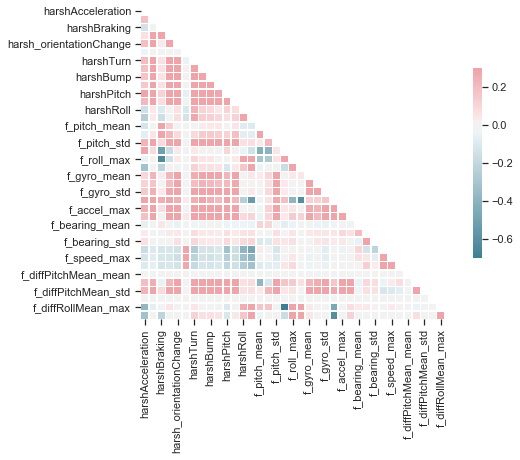

In [25]:
create_heat_map_plt(cleanFeatures)

In [26]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())
normalizedFeatures.head()


## Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


normalizedFeatures.head()

Min and Max values per column before normalization
harshAcceleration range:[0.0,0.18181818181818182]
harshAcceleration1 range:[0.0,0.17575757575757575]
harshBraking range:[0.0,0.17835497835497835]
harshBraking1 range:[0.0,0.11337579617834395]
harsh_orientationChange range:[0.0,0.1771343410687673]
harsh_speed_limit range:[0.0,0.028425504807336188]
harshTurn range:[0.0,0.12902674927231592]
harshTurn1 range:[0.0,0.12371730018788843]
harshBump range:[0.0,0.12093023255813953]
harshBump1 range:[0.0,0.18071958253227136]
harshPitch range:[0.0,0.1420213697670345]
harshPitch1 range:[0.0,0.18126888217522658]
harshRoll range:[0.0,0.12787878787878787]
harshRoll1 range:[0.0,0.18181818181818182]
f_pitch_mean range:[-87.61548492994265,87.30925356031214]
f_pitch_max range:[-80.31136341003527,89.9984816934055]
f_pitch_std range:[0.2136042774211785,81.24312603733985]
f_roll_mean range:[-155.1084827397622,165.30348447481762]
f_roll_max range:[-130.3066939592289,180.01325905069513]
f_roll_std range:[0.2621

,harshAcceleration,harshAcceleration1,harshBraking,harshBraking1,harsh_orientationChange,harsh_speed_limit,harshTurn,harshTurn1,harshBump,harshBump1,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,0.12076,0.00270,0.00000,0.00000,0.00178,0.00000,0.02449,0.00000,0.00261,0.00000,...,0.81427,0.18537,0.33493,0.43530,0.44932,0.12120,0.06437,0.71634,0.10010,0.04763
274877907034,0.01720,0.00000,0.00000,0.00000,0.00000,0.00677,0.00298,0.00000,0.00000,0.00000,...,0.40293,0.43689,0.50512,0.84812,0.30597,0.10865,0.03467,0.48505,0.10557,0.03579
884763263056,0.00865,0.00026,0.00000,0.00000,0.00101,0.00000,0.00836,0.00000,0.00074,0.00000,...,0.48170,0.45397,0.47500,0.72372,0.69148,0.17822,0.04933,0.45820,0.22146,0.09158
1073741824054,0.00709,0.00163,0.02571,0.00379,0.00243,0.00000,0.06219,0.00000,0.00829,0.00079,...,0.40384,0.22616,0.34039,0.44239,0.35721,0.18969,0.05807,0.58096,0.47207,0.34360
1056561954943,0.00113,0.00000,0.02571,0.00242,0.00155,0.00000,0.03183,0.00111,0.00566,0.00076,...,0.65512,0.54916,0.42431,0.47752,0.64870,0.30734,0.06314,0.58053,0.72346,0.45159


In [27]:
normalizedFeatures= (pd.merge(normalizedFeatures, df_labels, left_on='bookingID', right_on='bookingID', how='left'))
temp=normalizedFeatures.set_index('bookingID')



In [30]:
normalizedFeatures['label'].value_counts()

0    15003
1     4986
Name: label, dtype: int64

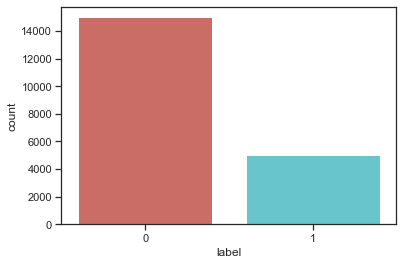

In [31]:
sns.countplot(x='label',data=normalizedFeatures, palette='hls')
plt.show()

In [32]:
count_no_sub = len(normalizedFeatures[normalizedFeatures['label']==0])
count_sub = len(normalizedFeatures[normalizedFeatures['label']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 75.056280954525
percentage of subscription 24.94371904547501


In [33]:
normalizedFeatures.groupby('label').mean().T

label,0,1
bookingID,805711016240.67224,847857210358.75110
harshAcceleration,0.03336,0.04710
harshAcceleration1,0.00269,0.00698
harshBraking,0.04502,0.05113
harshBraking1,0.00546,0.01348
harsh_orientationChange,0.00721,0.02204
harsh_speed_limit,0.00770,0.01314
harshTurn,0.03648,0.05167
harshTurn1,0.00389,0.01627
harshBump,0.00484,0.01588


In [38]:
X = normalizedFeatures.drop(columns=['label'])
X = X.drop(columns=['bookingID'])
y= normalizedFeatures['label']

In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  21040
Number of no subscription in oversampled data 10520
Number of subscription 10520
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [40]:
data_final_vars=normalizedFeatures.columns.values.tolist()
y=['label']
X=[i for i in data_final_vars if i not in y]

In [31]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14991, 38), (14991,), (4998, 38), (4998,))

In [41]:


from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)



C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sekaranh\Ap

[False  True  True False  True  True False  True  True  True  True False
 False  True False False  True False  True False False  True  True  True
  True  True False  True False  True  True False False  True False False
 False False]
[13  1  1 19  1  1  9  1  1  1  1  2 11  1 10  8  1 15  1 18  3  1  1  1
  1  1  6  1 16  1  1  4  7  1  5 12 14 17]


In [42]:
harish =os_data_X.columns
malan = rfe.support_
cols=[]
for i in range(len(harish)):
    if malan[i]:
        cols.append(harish[i])
        print(harish[i])

harshAcceleration1
harshBraking
harsh_orientationChange
harsh_speed_limit
harshTurn1
harshBump
harshBump1
harshPitch
harshRoll1
f_pitch_std
f_roll_max
f_gyro_max
f_gyro_std
f_accel_mean
f_accel_max
f_accel_std
f_bearing_max
f_speed_mean
f_speed_max
f_diffPitchMean_max


In [62]:
X=os_data_X[cols]
y=os_data_y['y']

In [63]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.644526
         Iterations 7
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.070     
Dependent Variable:    y                  AIC:                27161.6578
Date:                  2019-06-25 17:06   BIC:                27320.7414
No. Observations:      21040              Log-Likelihood:     -13561.   
Df Model:              19                 LL-Null:            -14584.   
Df Residuals:          21020              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        7.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
harshAcceleration1      -3.4583   1.3762  -2.5130 0

In [32]:
msk = np.random.rand(len(normalizedFeatures)) < 0.8
traindf = normalizedFeatures[msk]
evaldf = normalizedFeatures[~msk]
traindf.to_csv('train.csv',index=False,header=False)
evaldf.to_csv('eval.csv' ,index=False,header=False)

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.61


In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot
def plot_confusion_matrix(model):
    labels_predict = model.predict(x_test)
    cm = confusion_matrix(labels_predict, y_test, labels=normalizedFeatures.label.unique())
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f",
            cmap='Blues', square=True,
            xticklabels=normalizedFeatures.label.unique(),
            yticklabels=normalizedFeatures.label.unique())
    ax.set_xlabel('Predicted Activity')
    ax.set_ylabel('True Activity', )
    plt.tight_layout()
    ac = accuracy_score(y_test, labels_predict)
    rc = roc_auc_score(y_test, labels_predict)
    print("\nAccuracy {0} ROC {1}".format(ac, rc))
    #plt.savefig('confusionmatrix.pdf')

In [70]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot
def plot_acc_curve(model):
    labels_predict = model.predict(x_test)
    cm = confusion_matrix(labels_predict, y_test, labels=normalizedFeatures.label.unique())
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, __ = roc_curve(y_test,labels_predict)
    fig= plt.figure(figsize=(15,8))
    ax1=fig.add_subplot(1,3,1) 
    sns.heatmap(cm_normalized, annot=True, fmt=".4f",
            cmap='Blues', square=True,
            xticklabels=normalizedFeatures.label.unique(),
            yticklabels=normalizedFeatures.label.unique())
    ax1.set_xlabel('Predicted Activity')
    ax1.set_ylabel('True Activity', )
    ax2=fig.add_subplot(1,3,2)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.plot(fpr,tpr ,label=['ROC'],color='blue')
    ax2.grid(True, lw = 2, ls = '--', c = '.75')
    ax2.minorticks_on()
    ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    #ax2.title('Test ROC evaluation')
    ax2.legend(loc='best')
    plt.show()
   # plt.tight_layout()

In [53]:
def plot_feature_importances(model):
    plt.figure(figsize=(8,6))
    n_features = 50
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cleanFeatures)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    

In [71]:
# x_train = os_data_X
# y_train = os_data_y

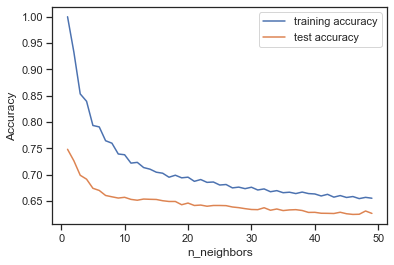

In [72]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(x_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(x_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

In [73]:
knn = KNeighborsClassifier(n_neighbors=51)
knn.fit(x_train, y_train)

print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(x_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(x_test, y_test)))
y_pred = knn.predict(x_test)

Accuracy of K-NN classifier on training set: 0.65
Accuracy of K-NN classifier on test set: 0.63


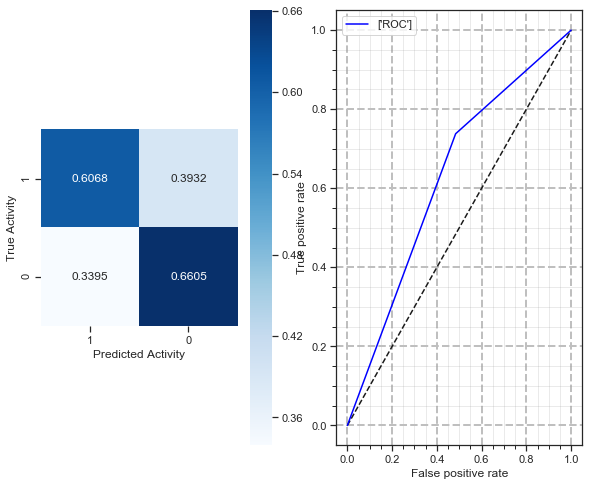

In [75]:
plot_acc_curve(knn)

C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set accuracy: 0.605
Test set accuracy: 0.614


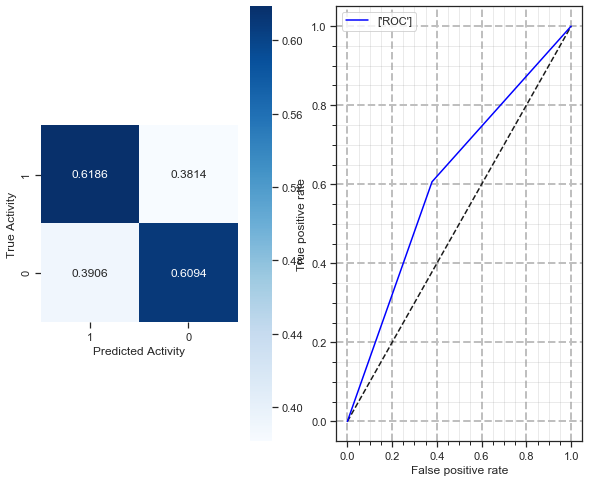

In [77]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(x_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg.score(x_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg.score(x_test, y_test)))
plot_acc_curve(logreg)

Accuracy on training set: 0.882
Accuracy on test set: 0.690


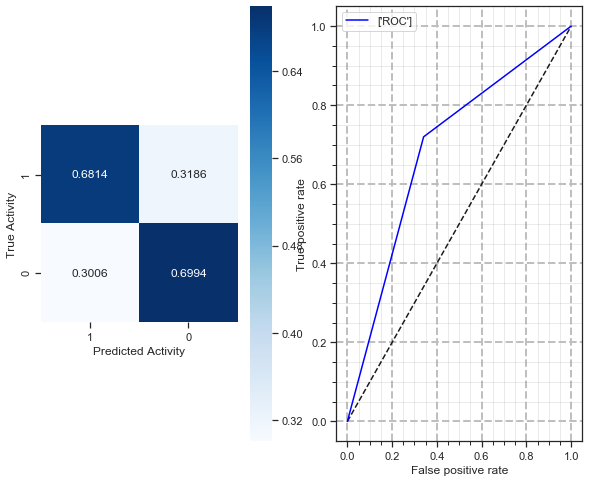

In [90]:
from sklearn.tree import DecisionTreeClassifier

tree = tree = DecisionTreeClassifier(max_depth=17, random_state=0)
tree.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test, y_test)))
plot_acc_curve(tree)


Accuracy on training set: 0.996
Accuracy on test set: 0.796


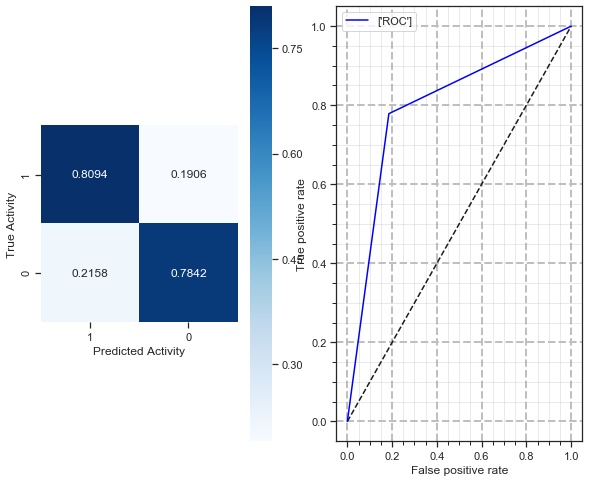

In [103]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(max_depth=19, n_estimators=1000, random_state=0)
rf1.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf1.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf1.score(x_test, y_test)))
plot_acc_curve(rf1)

Accuracy on training set: 0.765
Accuracy on test set: 0.740


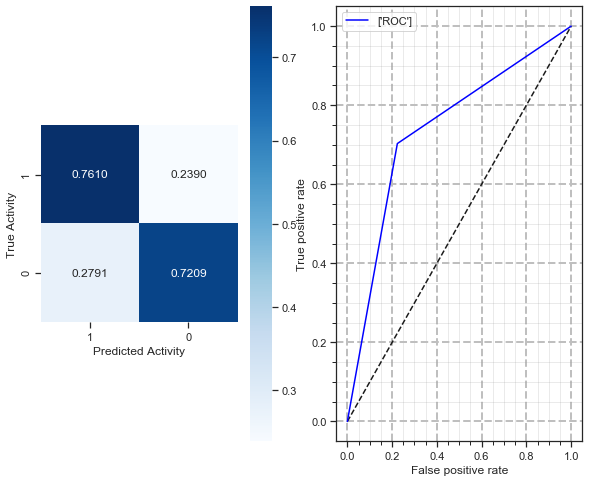

In [99]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(x_test, y_test)))
plot_acc_curve(gb)


C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.60
Accuracy on test set: 0.60


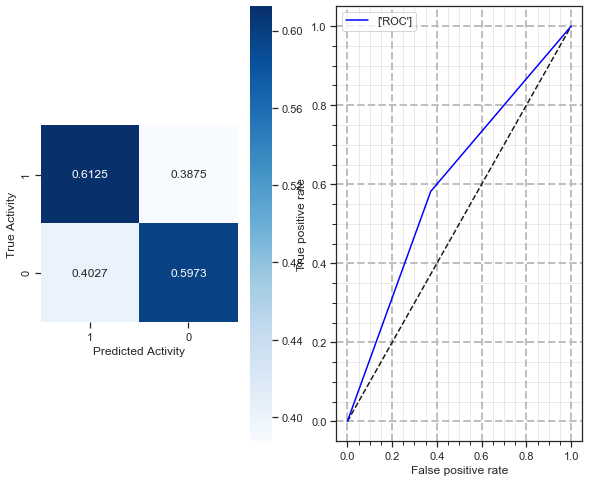

In [105]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(x_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(x_test, y_test)))

plot_acc_curve(svc)

Accuracy on training set: 0.989
Accuracy on test set: 0.790


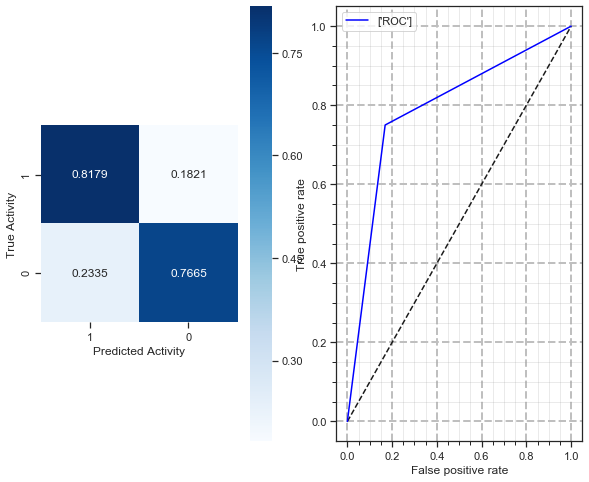

In [110]:
gb1 = GradientBoostingClassifier(random_state=0, max_depth=9)
gb1.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb1.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb1.score(x_test, y_test)))
plot_acc_curve(gb1)

C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy on training set: 0.64
Accuracy on test set: 0.63


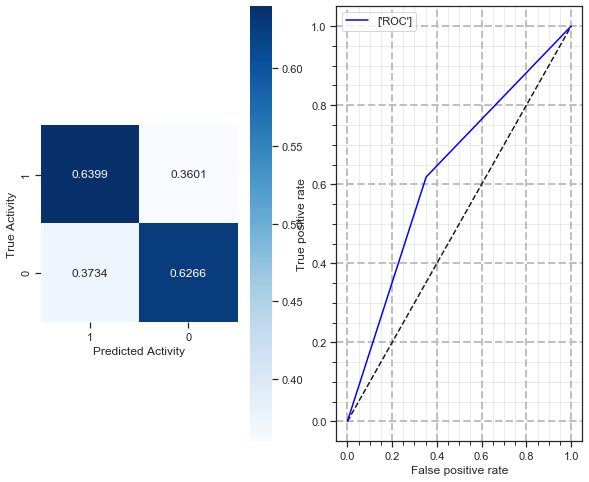

In [155]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(x_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(x_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(x_test, y_test)))
plot_acc_curve(mlp)

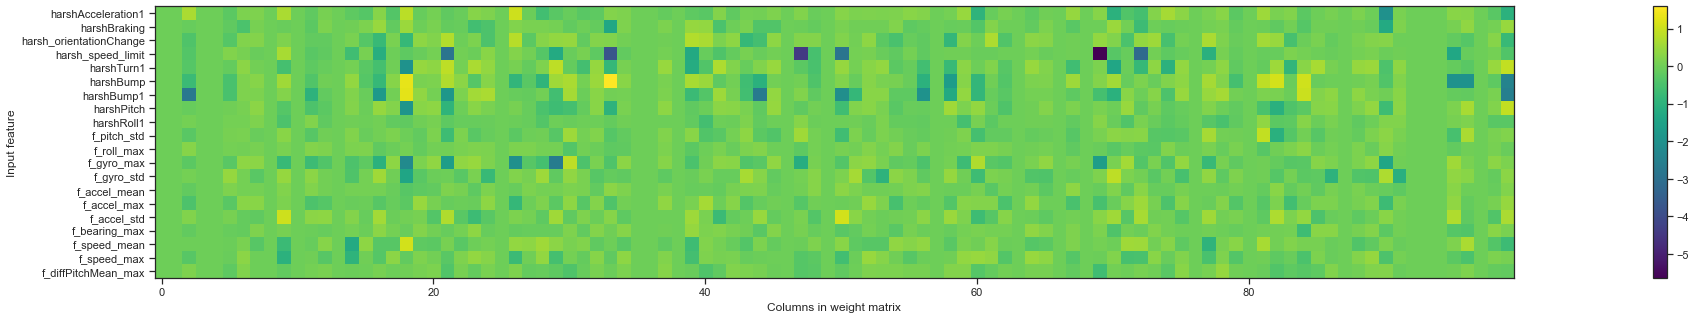

In [164]:
bookingID_features = x_test.columns

plt.figure(figsize=(50, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(20), bookingID_features)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

In [151]:
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV
params_grid = [
    {
        'eta':[0.01,0.05,0.1],
        'min_child_weight':[1,10,100],
        'max_depth':[3,5,7],
        'lambda':[0.01,0.1,1],
        'objective':['binary:logistic'],
        'eval_metric':['auc'],
        'seed':[42]
    }      
]
xgb = XGBClassifier()
grid_search = GridSearchCV(xgb, params_grid, cv = 10, n_jobs=-1, verbose=1)
grid_search.fit(x_train,y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 15.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_...=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid=[{'eta': [0.01, 0.05, 0.1], 'eval_metric': ['auc'],
                          'lambda': [0.01, 0.1, 1], 'max_depth': [3, 5, 7, 9],
                

In [152]:
grid_search.best_score_

0.7864611624117328

In [153]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot
def plot_acc_curve_2(model):
    best_model = grid_search.best_estimator_
    prob = best_model.predict_proba(x_test)[:,1]
    print('The validation AUC is :', roc_auc_score(y_test,prob))
    y_pred = [1 if x > 0.50 else 0 for x in prob]
    cm = confusion_matrix(y_pred, y_test, labels=normalizedFeatures.label.unique())
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, __ = roc_curve(y_test,prob)
    fig= plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,3,1) 
    sns.heatmap(cm_normalized, annot=True, fmt=".4f",
            cmap='Blues', square=True,
            xticklabels=normalizedFeatures.label.unique(),
            yticklabels=normalizedFeatures.label.unique())
    ax1.set_xlabel('Predicted Activity')
    ax1.set_ylabel('True Activity', )
    ax2=fig.add_subplot(1,3,2)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.plot(fpr,tpr ,label=['ROC'],color='blue')
    ax2.grid(True, lw = 2, ls = '--', c = '.75')
    ax2.minorticks_on()
    ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    #ax2.title('Test ROC evaluation')
    ax2.legend(loc='best')
    plt.savefig('final_modle')
    plt.show()

The validation AUC is : 0.8687238672787834


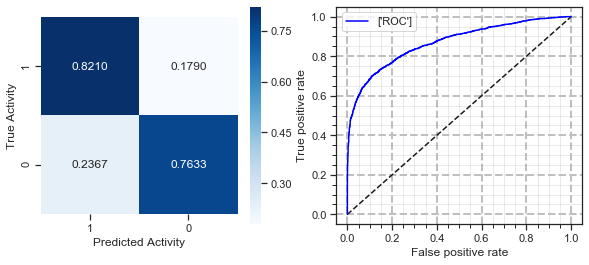

In [154]:
best_model = grid_search.best_estimator_
#prob = best_model.predict_proba(x_test)[:,1]
plot_acc_curve_2(best_model)
# print('The validation AUC is :', roc_auc_score(y_test,prob))
# fpr, tpr, __ = roc_curve(y_test,prob)
# plt.figure()
# plt.plot([0, 1], [0, 1], 'k--')

# plt.plot(fpr,tpr ,label=['ROC'],color='blue')
# plt.grid(True, lw = 2, ls = '--', c = '.75')
# plt.minorticks_on()
# plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('Test ROC evaluation')
# plt.legend(loc='best')
# plt.show()

This Data is not Enough we are able to to acthive accuracy of only 76%

In [103]:
# save model to file
model = grid_search.best_estimator_
pickle.dump(model, open("grab_safety_challange_model/model.dat", "wb"))

Index(['bookingID', 'harshAcceleration', 'harshAcceleration1', 'harshBraking',
       'harshBraking1', 'harsh_orientationChange', 'harsh_speed_limit',
       'harshTurn', 'harshTurn1', 'harshBump', 'harshBump1', 'harshPitch',
       'harshPitch1', 'harshRoll', 'harshRoll1', 'f_pitch_mean', 'f_pitch_max',
       'f_pitch_std', 'f_roll_mean', 'f_roll_max', 'f_roll_std', 'f_gyro_mean',
       'f_gyro_max', 'f_gyro_std', 'f_accel_mean', 'f_accel_max',
       'f_accel_std', 'f_bearing_mean', 'f_bearing_max', 'f_bearing_std',
       'f_speed_mean', 'f_speed_max', 'f_speed_std', 'f_diffPitchMean_mean',
       'f_diffPitchMean_max', 'f_diffPitchMean_std', 'f_diffRollMean_mean',
       'f_diffRollMean_max', 'f_diffRollMean_std', 'label'],
      dtype='object')

### DNN modle to increase Accuracy

In [107]:
## Define path data
COLUMNS = ['bookingID', 'harshAcceleration', 'harshAcceleration1', 'harshBraking',
       'harshBraking1', 'harsh_orientationChange', 'harsh_speed_limit',
       'harshTurn', 'harshTurn1', 'harshBump', 'harshBump1', 'harshPitch',
       'harshPitch1', 'harshRoll', 'harshRoll1', 'f_pitch_mean', 'f_pitch_max',
       'f_pitch_std', 'f_roll_mean', 'f_roll_max', 'f_roll_std', 'f_gyro_mean',
       'f_gyro_max', 'f_gyro_std', 'f_accel_mean', 'f_accel_max',
       'f_accel_std', 'f_bearing_mean', 'f_bearing_max', 'f_bearing_std',
       'f_speed_mean', 'f_speed_max', 'f_speed_std', 'f_diffPitchMean_mean',
       'f_diffPitchMean_max', 'f_diffPitchMean_std', 'f_diffRollMean_mean',
       'f_diffRollMean_max', 'f_diffRollMean_std', 'label']
PATH = 'train.csv'
PATH_test = 'eval.csv'

In [108]:
# df_train = pd.read_csv(PATH, skipinitialspace=True, names = COLUMNS, index_col=False)
# df_test = pd.read_csv(PATH_test,skiprows = 1, skipinitialspace=True, names = COLUMNS, index_col=False)

In [8]:
# print(df_train.shape, df_test.shape)

In [7]:
# print(df_train.dtypes)

In [126]:
# # COLUMNS_FEATURE = ['harshAcceleration', 'harshAcceleration1', 'harshBraking',
# #        'harshBraking1', 'harsh_orientationChange', 'harsh_speed_limit',
# #        'harshTurn', 'harshTurn1', 'harshBump', 'harshBump1', 'harshPitch',
# #        'harshPitch1', 'harshRoll', 'harshRoll1', 'f_pitch_mean', 'f_pitch_max',
# #        'f_pitch_std', 'f_roll_mean', 'f_roll_max', 'f_roll_std', 'f_gyro_mean',
# #        'f_gyro_max', 'f_gyro_std', 'f_accel_mean', 'f_accel_max',
# #        'f_accel_std', 'f_bearing_mean', 'f_bearing_max', 'f_bearing_std',
# #        'f_speed_mean', 'f_speed_max', 'f_speed_std', 'f_diffPitchMean_mean',
# #        'f_diffPitchMean_max', 'f_diffPitchMean_std', 'f_diffRollMean_mean',
# #        'f_diffRollMean_max', 'f_diffRollMean_std']
# COLUMNS_FEATURE = x_test.columns
# continuous_features = [tf.feature_column.numeric_column(k) for k in COLUMNS_FEATURE]

In [6]:
# model = tf.estimator.DNNLinearCombinedClassifier(
#     n_classes=2,
#     model_dir="ongoing/train15",
#     linear_optimizer=tf.train.FtrlOptimizer(learning_rate=0.001,l1_regularization_strength=0.7,l2_regularization_strength=5),
#     dnn_feature_columns=continuous_features,
#     dnn_hidden_units=[256,256, 50],
#     dnn_optimizer=tf.train.AdagradOptimizer(learning_rate=0.01))

In [128]:
# LABEL= 'label'
# def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
#     return tf.estimator.inputs.pandas_input_fn(
#        x=pd.DataFrame({k: data_set[k].values for k in COLUMNS_FEATURE}),
#        y = pd.Series(data_set[LABEL].values),
#        batch_size=n_batch,   
#        num_epochs=num_epochs,
#        shuffle=shuffle)

In [148]:
# model.train(input_fn=get_input_fn(x_train, 
#                                       num_epochs=None,
#                                       n_batch = 128,
#                                       shuffle=False),
#                                       steps=2000)

In [5]:
# model.evaluate(input_fn=get_input_fn(df_test, 
#                                       num_epochs=1,
#                                       n_batch = 128,
#                                       shuffle=False),
#                                       steps=2000)

In [117]:
# COLUMNS_FEATURE_REDUCED = ['harshAcceleration', 'harshAcceleration1', 'harshBraking',
#        'harshBraking1', 'harsh_orientationChange', 'harsh_speed_limit',
#        'harshTurn', 'harshTurn1', 'harshBump', 'harshBump1', 'harshPitch',
#        'harshPitch1', 'harshRoll', 'harshRoll1']
# continuous_features_reduce = [tf.feature_column.numeric_column(k) for k in COLUMNS_FEATURE]

In [4]:
# model = tf.estimator.DNNLinearCombinedClassifier(
#     n_classes=2,
#     model_dir="ongoing/train15",
#     linear_optimizer=tf.train.FtrlOptimizer(learning_rate=0.001,l1_regularization_strength=0.7,l2_regularization_strength=5),
#     dnn_feature_columns=continuous_features_reduce,
#     dnn_hidden_units=[256,256, 50],
#     dnn_optimizer=tf.train.AdagradOptimizer(learning_rate=0.01))

In [119]:
# LABEL= 'label'
# def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
#     return tf.estimator.inputs.pandas_input_fn(
#        x=pd.DataFrame({k: data_set[k].values for k in COLUMNS_FEATURE}),
#        y = pd.Series(data_set[LABEL].values),
#        batch_size=n_batch,   
#        num_epochs=num_epochs,
#        shuffle=shuffle)

In [3]:
# model.train(input_fn=get_input_fn(df_train, 
#                                       num_epochs=None,
#                                       n_batch = 128,
#                                       shuffle=False),
#                                       steps=2000)

In [2]:
# model.evaluate(input_fn=get_input_fn(df_test, 
#                                       num_epochs=1,
#                                       n_batch = 128,
#                                       shuffle=False),
#                                       steps=2000)

To improve the accuracy we need more Data, last model is using only COLUMNS_FEATURE_REDUCED 
'harshAcceleration',  'harshBraking','harsh_orientationChange', 'harsh_speed_limit','harshTurn',, 'harshBump',  'harshPitch',
 'harshRoll.
       


In [1]:
# best_model = grid_search.best_estimator_
# prob = best_model.predict_proba(x_test)[:,1]

# print('The validation AUC is :', roc_auc_score(y_test,prob))
# fpr, tpr, __ = roc_curve(y_test,prob)
# plt.figure()
# plt.plot([0, 1], [0, 1], 'k--')

# plt.plot(fpr,tpr ,label=['XGBoost'],color='blue')
# plt.grid(True, lw = 2, ls = '--', c = '.75')
# plt.minorticks_on()
# plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('Test ROC evaluation')
# plt.legend(loc='best')
# plt.show()

In [170]:
# from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
# from matplotlib import pyplot
# def plot_acc_curve_1(model):
#     labels_predict = model.predict(x_test)
#     print('The validation AUC is :', roc_auc_score(y_test,labels_predict))
#     cm = confusion_matrix(labels_predict, y_test, labels=normalizedFeatures.label.unique())
#     cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     fpr, tpr, __ = roc_curve(y_test,labels_predict)
#     fig= plt.figure(figsize=(15,4))
#     ax1=fig.add_subplot(1,3,1) 
#     sns.heatmap(cm_normalized, annot=True, fmt=".4f",
#             cmap='Blues', square=True,
#             xticklabels=normalizedFeatures.label.unique(),
#             yticklabels=normalizedFeatures.label.unique())
#     ax1.set_xlabel('Predicted Activity')
#     ax1.set_ylabel('True Activity', )
#     ax2=fig.add_subplot(1,3,2)
#     ax2.plot([0, 1], [0, 1], 'k--')
#     ax2.plot(fpr,tpr ,label=['ROC'],color='blue')
#     ax2.grid(True, lw = 2, ls = '--', c = '.75')
#     ax2.minorticks_on()
#     ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#     ax2.set_xlabel('False positive rate')
#     ax2.set_ylabel('True positive rate')
#     #ax2.title('Test ROC evaluation')
#     ax2.legend(loc='best')
#     plt.show()

In [219]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot
def plot_acc_curve_2(model):
    best_model = grid_search.best_estimator_
    prob = best_model.predict_proba(x_test)[:,1]
    print('The validation AUC is :', roc_auc_score(y_test,prob))
    y_pred = [1 if x > 0.60 else 0 for x in prob]
    cm = confusion_matrix(y_pred, y_test, labels=normalizedFeatures.label.unique())
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, __ = roc_curve(y_test,prob)
    fig= plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,3,1) 
    sns.heatmap(cm_normalized, annot=True, fmt=".4f",
            cmap='Blues', square=True,
            xticklabels=normalizedFeatures.label.unique(),
            yticklabels=normalizedFeatures.label.unique())
    ax1.set_xlabel('Predicted Activity')
    ax1.set_ylabel('True Activity', )
    ax2=fig.add_subplot(1,3,2)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.plot(fpr,tpr ,label=['ROC'],color='blue')
    ax2.grid(True, lw = 2, ls = '--', c = '.75')
    ax2.minorticks_on()
    ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    #ax2.title('Test ROC evaluation')
    ax2.legend(loc='best')
    plt.savefig('final_modle')
    plt.show()

In [156]:
RELEVANT_EVENTS = x_train.columns
drop_these = list(set(list(normalizedFeatures)) - set(RELEVANT_EVENTS))
df_final =  normalizedFeatures.drop(drop_these, axis = 1)

<Figure size 432x288 with 0 Axes>

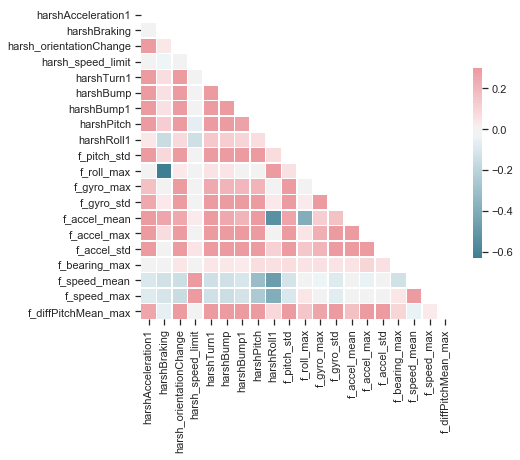

In [157]:
create_heat_map_plt(df_final)

#### gradient boosted decision trees (using XGBOOST)

The validation AUC is : 0.8687238672787834


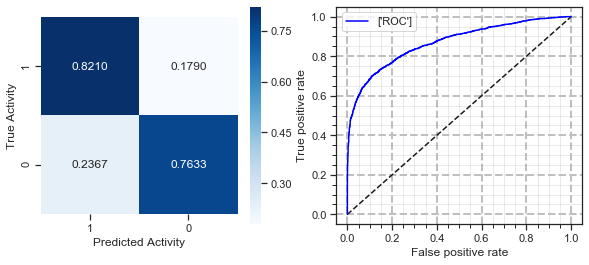

In [158]:
plot_acc_curve_2(best_model)

#### Conclusion
#### Best model is gradient boosted decision tree, Since Dataset is Imbalance, model was favering safe driving, after oversampling the dataset ROC accuracy increaed to 86%